## Safety: Major Crimes and Vaccination
#### Sam Brunacini

The goal here is to combine information about violent crime and vaccination into a single number ("safety index") that shows how safe a neighborhood is.

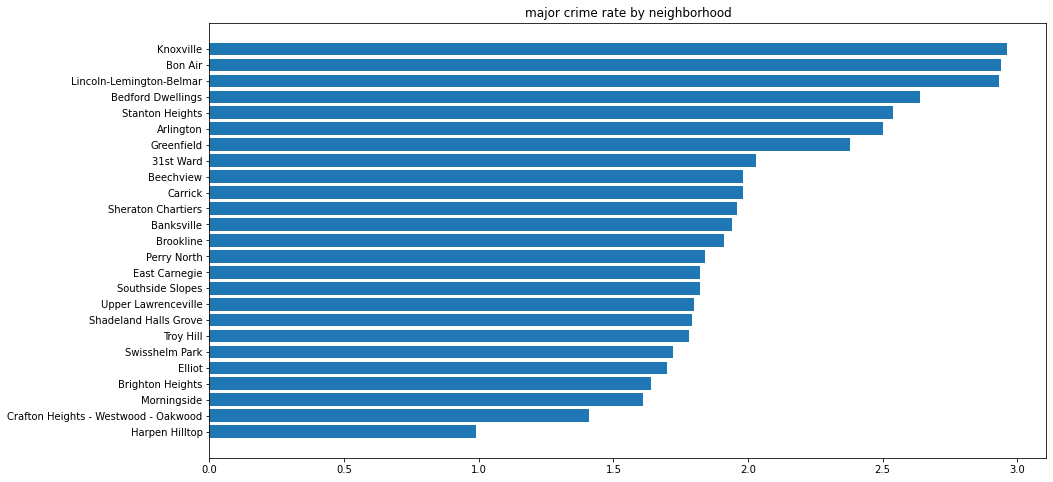

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8] # make it bigger
df2 = pd.read_csv("crimes.csv")
df2.sort_values("overall_crime_rate", inplace=True) # sort by crime rate so it's easier to read
index = df2.iloc[:, 3] < 3 # only show the best ones
plt.title("major crime rate by neighborhood")
plt.barh(df2.iloc[:, 1][index], df2.iloc[:, 3][index])
plt.show()

Shadyside doesn't appear as one of the top neighborhoods by this metric, but it still ends up winning in the combined measurement. It's important to note that this dataset includes all of Allegheny County, not just neighborhoods in Pittsburgh. That problem will be taken care of later when we restrict our view to neighborhoods that only appear in both datasets.

In [5]:
plt.rcParams['figure.figsize'] = [15, 10] # even bigger
df = pd.read_csv("covid.csv")
df.sort_values("bivalent_booster", ascending=False, inplace=True) # sort by vaccination to make visualization cleaner

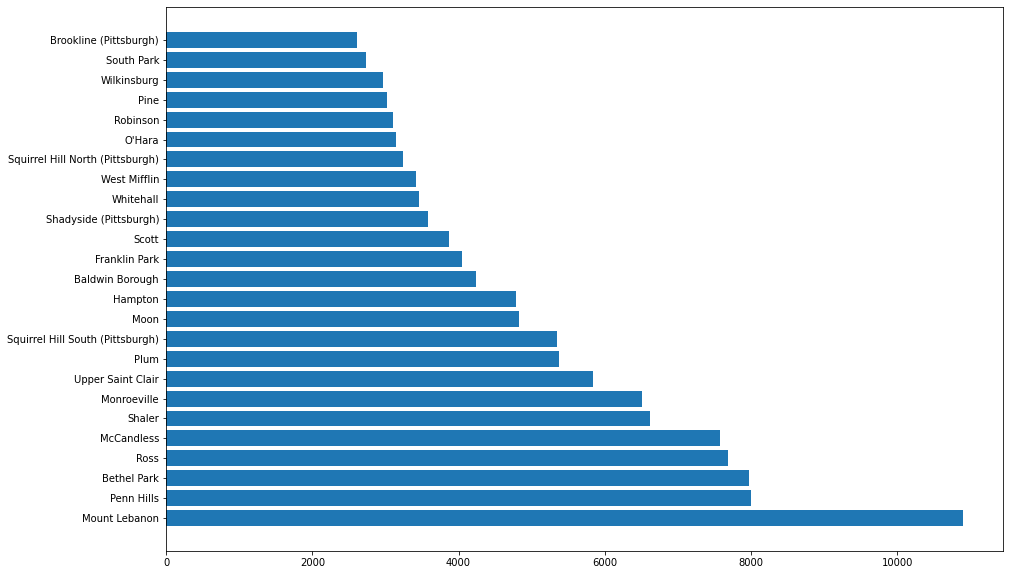

In [6]:
top = df.head(25)
plt.barh(top["neighborhood_municipality"], top["bivalent_booster"])
plt.show()

Here, we see Shadyside come out 16th, which is pretty good.

## Safety index calculations

In [7]:
raw = list(df2["neighborhood"])
cleaned = [name.lower().replace(" ", "").replace("'", "").replace("-", "") for name in raw]
cleaned.sort()

In [8]:
raw2 = list(df["neighborhood_municipality"])
cleaned2 = [name.lower().replace(" ", "").replace("'", "").replace("-", "") for name in raw2]
cleaned2.sort()
cleaned2 = [name.replace("(pittsburgh)", "") for name in cleaned2 if "(pittsburgh)" in name]

In [12]:
shared = set(cleaned).intersection(set(cleaned2))
", ".join(shared)

'brookline, perrysouth, lowerlawrenceville, esplen, alleghenywest, garfield, greenfield, highlandpark, upperlawrenceville, brightonheights, homewoodsouth, middlehill, homewoodnorth, upperhill, southoakland, northoakland, banksville, southsideflats, centralnorthside, swisshelmpark, morningside, alleghenycenter, larimer, stantonheights, homewoodwest, bonair, easthills, bloomfield, terracevillage, beltzhoover, eastcarnegie, arlington, manchester, shadyside, regentsquare, arlingtonheights, lincolnlemingtonbelmar, perrynorth, polishhill, carrick, beechview, knoxville, friendship, eastliberty, allentown, bedforddwellings, southsideslopes, st.clair, troyhill, northviewheights, pointbreeze'

We are only interested in neighborhoods that have data from both datasets, because we need both to calculate the index. Since the second dataset only contains Pittsburgh data, we get the added bonus of eliminating irrelevant data from neighborhoods outside Pittsburgh.

In [13]:
def is_shared(entry):
    entry = entry.str.lower()
    entry = entry.str.replace(" ", "")
    entry = entry.str.replace("'", "")
    entry = entry.str.replace("-", "")
    entry = entry.str.replace("\(pittsburgh\)", "", regex=True)
    result = [] # yeah this is kinda bad, but it does the trick and it's fine for relatively small datasets
    for item in list(entry):
        if item in shared:
            result.append(True)
        else: result.append(False)
    return result

This is a custom filter. This is to make it easier to select only the data that is shared by both datasets.

In [26]:
cleaned_crime_df = df2[is_shared(df2["neighborhood"])]
cleaned_covid_df = df[is_shared(df["neighborhood_municipality"])]
cleaned_crime_df = cleaned_crime_df.sort_values("neighborhood")
cleaned_covid_df = cleaned_covid_df.sort_values("neighborhood_municipality")

In [27]:
import numpy as np
arr1 = np.array(cleaned_crime_df["overall_crime_rate"])
arr2 = np.array(cleaned_covid_df["bivalent_booster"])
final_score = arr2 - 10 * arr1
winning_index= np.argmax(final_score)

This is where I calculate the weighted average:

$$\text{safety index} = \text{Covid vaccinations} - 10\left( \text{violent crime rate} \right)$$

It's weighted this way simply to account for the difference in average order of magnitude of the two data points. Crime rate is always between 0 and 100, and the vaccinations are typically in the thousands. `winning_index` is the index of the neighborhood with the best safety index.

In [28]:
cleaned_crime_df.iloc[winning_index]

_id                               53
neighborhood               Shadyside
population                     16867
overall_crime_rate              7.26
number_arrests_murder              0
crime_rate_murder                0.0
number_arrests_rape               24
crime_rate_rape                 0.14
number_arrests_robbery           148
crime_rate_robbery              0.87
number_arrests_assault            83
crime_rate_assault              0.49
number_arrests_burglary          482
crime_rate_burglary             2.85
number_arrests_larceny           492
crime_rate_larceny              2.91
Name: 52, dtype: object

As a sanity check, we should get the same winning neighborhood by indexing into either dataset.

In [29]:
cleaned_covid_df.iloc[winning_index]

_id                                           25623
neighborhood_municipality    Shadyside (Pittsburgh)
bivalent_booster                               3584
Name: 146, dtype: object

Just for fun, let's also see what the worst neighborhood is.

In [30]:
losing_index = np.argmin(final_score)
cleaned_crime_df.iloc[losing_index]

_id                                       2
neighborhood               Allegheny Center
population                              588
overall_crime_rate                    52.04
number_arrests_murder                     0
crime_rate_murder                       0.0
number_arrests_rape                       2
crime_rate_rape                        0.34
number_arrests_robbery                   24
crime_rate_robbery                     4.08
number_arrests_assault                   30
crime_rate_assault                      5.1
number_arrests_burglary                  14
crime_rate_burglary                    2.38
number_arrests_larceny                  236
crime_rate_larceny                    40.14
Name: 1, dtype: object

A bar graph, in case we want to use it for the presentation.

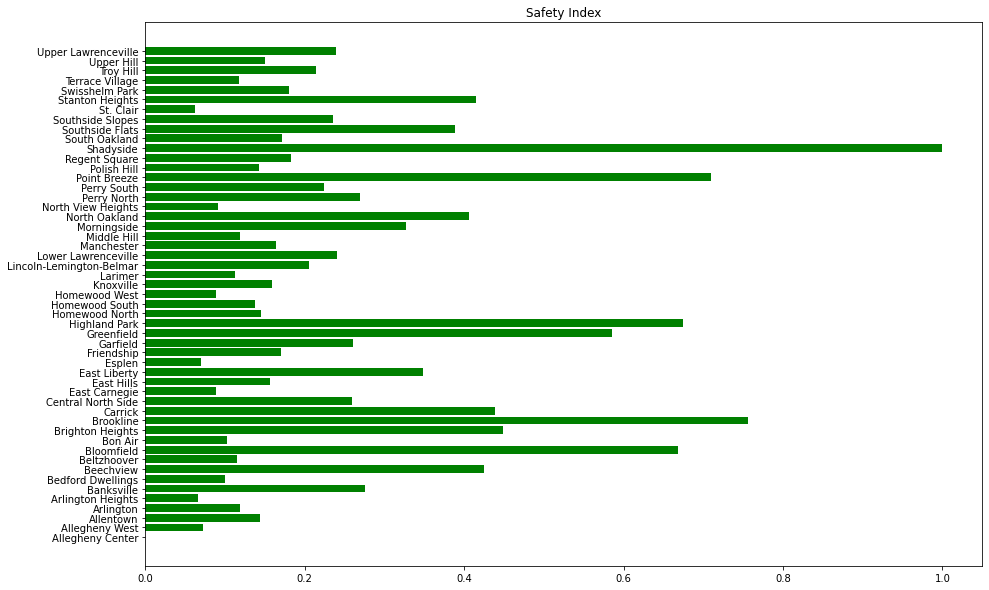

In [33]:
normalized = (final_score - np.min(final_score)) / (np.max(final_score) - np.min(final_score)) # see below
plt.barh(cleaned_crime_df["neighborhood"], normalized, color="g")
plt.title("Safety Index")
plt.show()

I had to do a normalization step here because Allegheny Center is apparently so bad that it has a negative index, and it was making things look messy. The normalization is pretty standard:

$$ \text{normalized}(x) = \frac{x-\min(\text{index})}{\max(\text{index}) - \min(\text{index})} $$

Subtracting the minimum index brings the lowest value to zero, the highest value to $\max(\text{index}) - \min(\text{index})$, and preserves order. Dividing by $\max(\text{index}) - \min(\text{index})$ therefore makes everything between 0 and 1.

## Conclusion

Shadyside has the highest safety index, so according to my datasets, it's the best neighborhood.

While it's kind of hard to deny the findings of our analysis of the data, it has made basically zero impact on my opinion about what the best neighborhood is. To me, South Oakland is the best neighborhood. There isn't even any real justification to this, and by many good metrics it's objectively untrue, and most people would probably agree that Shadyside is way better than South Oakland. Since this part is subjective, though, I would still say it's the best neighborhood. I live there, all my friends live there, and there are a lot of friendly stray cats everywhere. It's also home to Dan Marino park (if you can call it a park?) which immediately puts it head and shoulders above everywhere else.

South Oakland definitely has some issues with safety. I don't recommend anyone goes walking around alone at later hours or early in the morning, but it's still pretty safe even though it's bad compared to other neighborhoods. There is no neighborhood anywhere in Pittsburgh that compares to where I came from in New York in terms of how much violence and crime and just general sketchy stuff going on all the time. So in my view, it's a big improvement. Everybody always complains about how much trash there is along the side of the road, but I honestly don't see the difference between South Oakland and other areas of the city in this respect. South Oakland also has neighborhood volunteer clean ups multiple times a year and they always have a bunch of people show up. Nothing against Shadyside, but I don't think I would like living there as much.